<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Deterministic Creation of Multi-Qubit W State Systems

## _*Benchmarking Competing Algorithms by Quantum Tomography*_ 


***
### Contributors
Pierre Decoodt


A generalized $n$-qubit W state system can be written as$^{[1]}$:
$$ |W_{n}\rangle \; = \; \sqrt{\frac{1}{n}} \: (\:|10...0\rangle \: +  |01...0\rangle \: +...+ |00...1\rangle \:) $$

A specific compact algorithm allows the deterministic creation of W states of any size $n$., as described here:

https://nbviewer.jupyter.org/github/QISKit/qiskit-tutorial/blob/master/appendix/teach_me_qiskit_2018/w_state/W%20State%201%20-%20Multi-Qubit%20Systems.ipynb

This algorithm is inspired by Diker's theoretical proposition$^{[2]}$, but is characterized by a linear rather than quadratic progression of the number of gates needed when  $ n $ increases.

In many cases, the QISKit compiler is so smart that it allows safely the programming of circuits without taking into account the architecture of the different final real target devices. This is the approach that is presented here with realization of a compact multi-qubit W state generation program.

For the creation of such states, an other approach is to use a general algorithm of arbitrary initialization, as described in the last part of the following tutorial:

https://nbviewer.jupyter.org/github/QISKit/qiskit-tutorial/blob/master/reference/tools/quantum_gates_and_linear_algebra.ipynb

Therefore, why worry about using a specific algorithm, sophisticated on the theoretical level, while a ready-made alternative, valid for any entangled state, is at our disposal?

It therefore seemed interesting to compare the two approaches by using quantum fidelity as a benchmark, with the help of the methodology presented here:

https://nbviewer.jupyter.org/github/QISKit/qiskit-tutorial/blob/master/reference/qcvv/state_tomography.ipynb (the code to calculate the quantum fidelity used here comes mostly from this last tutorial).

As you will see at the end of the notebook in the "results" section, one of the algorithms in competition clearly outperforms the other...

In [1]:
#Getting a pass
import sys, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please input your token and hit enter: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.')

Please input your token and hit enter: ········
Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.


In [2]:
#Importing packages

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
# importing the QISKit
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, QuantumProgram

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram
from qiskit.tools.qi.qi import state_fidelity, outer
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer, qx_color_scheme
%config InlineBackend.figure_format = 'svg'

In [3]:
# Register API token for online backends
qiskit.register(qx_config['APItoken'], qx_config['url'])

In [4]:
# Determining the job
n = int(input("type number of qubits + enter: "))

# Creating a n-qubit quantum register
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
my_state = QuantumCircuit(qr, name='my_state')

# Desired vector for a n-qubit W state
desired_vector = []
qr_vector = []
n_vector = 2**n
for i in range(n_vector):
        desired_vector.append(0)
for j in range(n) :           
        desired_vector[2**j] = 1/np.sqrt(n)

        
# Choice of the circuit building method (arbitrary or specific)        
print("Do you want to use the specific method?")
W_state_circuit = input("    Answer by (y/n) + enter\n").upper()

if (W_state_circuit == "N") :
# Initializing a n-qubit W quantum state using the arbitrary method   
    for j in range(n) :                   
        qr_vector.append(qr[j])
    my_state.initialize(desired_vector, qr_vector)

else:
# Quantum circuit to make a n-qubit W state using the specific method
    my_state.x(qr[n-1]) #start is |10...0>
    for i in range(1,n) :
        theta = np.arccos(np.sqrt(1/(n-i+1)))
        my_state.ry(-theta,qr[n-i-1])       
        my_state.cz(qr[n-i],qr[n-i-1])
        my_state.ry(theta,qr[n-i-1])
    for i in range(1,n) :
        my_state.cx(qr[n-i-1],qr[n-i])

type number of qubits + enter: 4
Do you want to use the specific method?
    Answer by (y/n) + enter
y


In [5]:
#Test circuit "my_state"  : Measurements
measuring = QuantumCircuit(qr, cr, name='measuring')
for i in range(n) :
    measuring.measure(qr[i] , cr[i])
test = my_state+measuring

start my state 4 -qubit on local_qasm_simulator N= 1024 19/07/2018 22:31:10


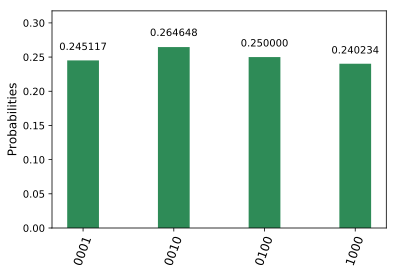

In [6]:
#Test circuit "my_state" : Simulator
backend="local_qasm_simulator"
#backend ='ibmq_qasm_simulator'
shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start my state',n, '-qubit on', backend, "N=", shots,time_exp)
job = qiskit.execute(test, backend=backend, shots=shots, max_credits=5)
plot_histogram(job.result().get_counts(test))

start my state 4 -qubit on ibmqx4 N= 1024 17/07/2018 22:54:29
{'0000': 94, '0001': 147, '0010': 119, '0011': 7, '0100': 140, '0101': 4, '0110': 16, '0111': 6, '1000': 294, '1001': 17, '1010': 25, '1011': 11, '1100': 115, '1101': 11, '1110': 18}


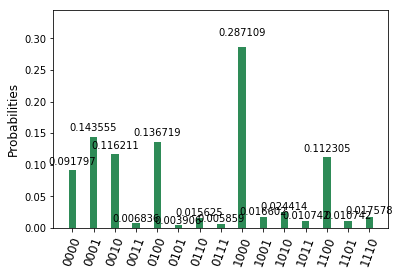

In [100]:
#Test circuit "my_state" : Real Quantum Computer

#Choosing the backend
backend = 'ibmqx4'
#backend = 'ibmq_qasm_simulator' # if the real devices are too busy or as a final precautionary test

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start my state',n, '-qubit on', backend, "N=", shots,time_exp)
job = qiskit.execute(test, backend=backend, shots=shots, max_credits=5)
print(job.result().get_counts(test))
plot_histogram(job.result().get_counts(test))

In [102]:
# Quantum fidelity on a real device

# Obtaining the final state vector

job = qiskit.execute(my_state, backend='local_statevector_simulator')
my_state_psi = job.result().get_statevector(my_state)


# Construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set)

# Create a quantum program containing the state preparation circuit
Q_program = QuantumProgram()
Q_program.add_circuit('my_state', my_state)

# Add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuit_names = tomo.create_tomography_circuits(Q_program, 'my_state', qr, cr, my_state_tomo_set)

#Choosing the backend
backend = 'ibmqx4'
#backend = 'ibmq_qasm_simulator' # if the real devices are too busy or as a precautionary test

# Take 1024 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 1024
# set max credits
max_credits = 8

# Run the experiment
status = qiskit.get_backend(backend).status
if status['operational'] == False or status['pending_jobs'] > 40:
    print('Warning: the selected backend appears to be busy or unavailable at present; consider choosing a different one if possible')
my_stateqx_tomo_result = Q_program.execute(my_state_tomo_circuit_names, backend=backend, shots=shots,
                           max_credits=max_credits)

# Extracting tomography data from results
my_stateqx_tomo_data = tomo.tomography_data(my_stateqx_tomo_result, 'my_state', my_state_tomo_set)

# Reconstruct experimentally measured density matrix 
rho_fit_real = tomo.fit_tomography_data(my_stateqx_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('my state',n, '-qubit on', backend, "N=", shots,time_exp)
F_fit_real = state_fidelity(rho_fit_real, my_state_psi)
print('Fidelity with ideal state')
print('F =', F_fit_real)

my state 4 -qubit on ibmqx4 N= 1024 18/07/2018 07:15:06
Fidelity with ideal state
F = 0.5926472894123553


### Results:

The following results were obtained on the ibmqx4 using 1024 shots in each experiment:

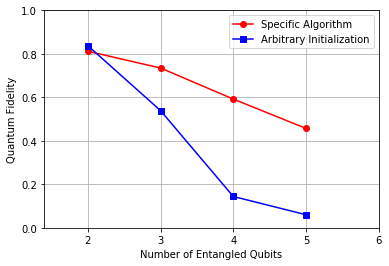

In [105]:
plt.xlabel('Number of Entangled Qubits')
plt.ylabel('Quantum Fidelity')
plt.axis([1.4, 6, 0, 1])
plt.grid()
plt.plot([2,3,4,5], [0.812,0.735,0.592,0.457], 'ro-', label="Specific Algorithm")
plt.plot([2,3,4,5], [0.838,0.539,0.144,0.060], 'bs-', label="Arbitrary Initialization")
plt.legend()
plt.show()

### Concluding remark:


The efficiency of the more compact specific algorithm as a deterministic $ |W_{n}\rangle$ production tool, when estimated from the quantum fidelity, is clearly related to the linear progression of the number of required gates when n increases. On the other hand, the arbitrary initialization requires a number of gate increasing geometrically.
This can be appreciated for instance by comparing the circuits for a given n:


type number of qubits + enter: 3
Comparing Circuits for Specific Algorithm and Arbitrary Initialisation: 



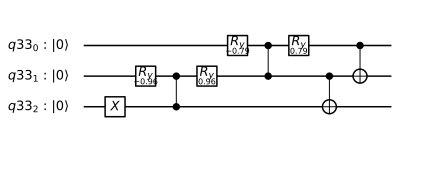

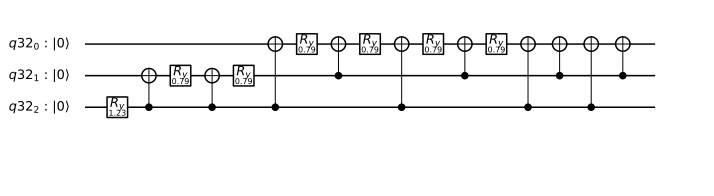

In [22]:
# Comparing circuits for n qubits
n = int(input("type number of qubits + enter: "))

# Creating a n-qubit quantum register
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
my_state_arbitrary = QuantumCircuit(qr, name='my_state__arbitrary')
qs = QuantumRegister(n)
cs = ClassicalRegister(n)
my_state_specific = QuantumCircuit(qs, name='my_state_specific')

# Desired vector for a n-qubit W state
desired_vector = []
qr_vector = []
n_vector = 2**n
for i in range(n_vector):
        desired_vector.append(0)
for j in range(n) :           
        desired_vector[2**j] = 1/np.sqrt(n)        

# Initializing a n-qubit W quantum state using the arbitrary method   
for j in range(n) :                   
    qr_vector.append(qr[j])
my_state_arbitrary.initialize(desired_vector, qr_vector)

# Quantum circuit to make a n-qubit W state using the specific method
my_state_specific.x(qs[n-1]) #start is |10...0>
for i in range(1,n) :
    theta = np.arccos(np.sqrt(1/(n-i+1)))
    my_state_specific.ry(-theta,qs[n-i-1])       
    my_state_specific.cz(qs[n-i],qs[n-i-1])
    my_state_specific.ry(theta,qs[n-i-1])
for i in range(1,n) :
    my_state_specific.cx(qs[n-i-1],qs[n-i])

#drawing the circuit
my_style = {'latexdrawerstyle': True}
print("Comparing Circuits for Specific Algorithm and Arbitrary Initialization:",'\n')
drawer(my_state_specific, style=my_style, scale = 0.5)
drawer(my_state_arbitrary, style=my_style, scale = 0.5)

### References:

[1] Dür, W., Vidal, G., & Cirac, J. I. (2000). Three qubits can be entangled in two inequivalent ways. Physical Review A, 62(6), 062314. 

[2] Diker, F. (2016). Deterministic construction of arbitrary W states with quadratically increasing number of two-qubit gates. arXiv preprint arXiv:1606.09290
